# Part 4: Strategic Decision System

## Objective
Build a model/system that helps businesses determine which campaigns should continue and which should stop.

## Approach
1. Define success metrics and thresholds
2. Build a scoring model to evaluate campaign performance
3. Create an actionable recommendation system
4. Apply to real campaigns and demonstrate reasoning
5. Design delivery mechanism for stakeholders

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Load and Prepare Data

In [ ]:
# Load all datasets
campaigns = pd.read_csv('../dashboard/data/campaigns.csv')
campaign_leads = pd.read_csv('../dashboard/data/campaign_leads.csv')
campaign_metrics = pd.read_csv('../dashboard/data/campaign_metrics.csv')
lead_status_changes = pd.read_csv('../dashboard/data/lead_status_changes.csv')

print("Campaigns shape:", campaigns.shape)
print("Campaign Leads shape:", campaign_leads.shape)
print("Campaign Metrics shape:", campaign_metrics.shape)
print("Lead Status Changes shape:", lead_status_changes.shape)

Campaigns shape: (7364, 6)
Campaign Leads shape: (56965, 7)
Campaign Metrics shape: (4020, 15)
Lead Status Changes shape: (38925, 3)


In [8]:
# Check actual column names
print("Campaigns columns:", campaigns.columns.tolist())
print("\nCampaign Metrics columns:", campaign_metrics.columns.tolist())
print("\nCampaign Leads columns:", campaign_leads.columns.tolist())
print("\nLead Status Changes columns:", lead_status_changes.columns.tolist())

Campaigns columns: ['id', 'daily_budget', 'start_time', 'stop_time', 'user_id', 'project_name']

Campaign Metrics columns: ['Unnamed: 0', 'campaign_id', 'start_date', 'end_date', 'project_name', 'num_leads', 'daily_budget', 'duration', 'budget', 'clicks', 'impressions_ins', 'reach_ins', 'spend', 'ctr', 'cpl']

Campaign Leads columns: ['id', 'campaign_id', 'name', 'email', 'phone', 'lead_status', 'added_date']

Lead Status Changes columns: ['lead_id', 'status', 'created_at']


In [9]:
# Parse dates and rename columns for consistency
campaigns['start_date'] = pd.to_datetime(campaigns['start_time'])
campaigns['end_date'] = pd.to_datetime(campaigns['stop_time'])
campaigns['campaign_id'] = campaigns['id']
campaigns['campaign_name'] = campaigns['project_name']

campaign_metrics['date'] = pd.to_datetime(campaign_metrics['start_date'])
campaign_metrics['cost'] = campaign_metrics['spend']
campaign_metrics['conversions'] = campaign_metrics['num_leads']  # Using leads as conversions
campaign_metrics['impressions'] = campaign_metrics['impressions_ins']

campaign_leads['added_date'] = pd.to_datetime(campaign_leads['added_date'])
lead_status_changes['changed_at'] = pd.to_datetime(lead_status_changes['created_at'])

# Calculate campaign duration
campaigns['duration_days'] = (campaigns['end_date'] - campaigns['start_date']).dt.days

print("\nCampaigns date range:", campaigns['start_date'].min(), "to", campaigns['end_date'].max())
print("Metrics date range:", campaign_metrics['date'].min(), "to", campaign_metrics['date'].max())
print("\nData loaded and prepared successfully!")


Campaigns date range: 2024-06-01 01:40:49 to 2025-10-07 23:59:59
Metrics date range: 2024-06-01 00:00:00 to 2025-01-04 00:00:00

Data loaded and prepared successfully!


## 2. Define Success Metrics

To determine if a campaign should continue, we need to define what "success" means. For real estate lead generation, I propose a multi-dimensional scoring system based on:

### Primary Metrics (Business Value)
1. **Cost Per Qualified Lead (CPQL)** - How much does it cost to get a lead that actually converts?
2. **Lead Quality Rate** - What percentage of leads become qualified?
3. **ROI Efficiency** - Are we getting value relative to spend?

### Secondary Metrics (Performance Indicators)
4. **Trend Direction** - Is performance improving or declining?
5. **Volume Adequacy** - Do we have enough leads to be statistically meaningful?
6. **Engagement Quality** - Are leads actually engaging (clicks, conversions)?

### Business Context
7. **Campaign Maturity** - New campaigns need time to optimize
8. **Strategic Value** - Some campaigns may be worth continuing for strategic reasons (brand awareness, market testing)

In [10]:
# Campaign metrics are already aggregated in this dataset, so we'll use them directly
campaign_performance = campaign_metrics[['campaign_id', 'impressions', 'clicks', 'cost', 'conversions']].copy()

# Determine qualified leads based on lead_status
# Assuming 'qualified' or similar status indicates a qualified lead
qualified_statuses = campaign_leads['lead_status'].unique()
print("Available lead statuses:", qualified_statuses)

# Define what counts as "qualified" - adjust this based on actual status values
# Typically: qualified, hot, warm, opportunity, etc.
qualified_keywords = ['qualified', 'hot', 'warm', 'opportunity', 'interested']
campaign_leads['is_qualified'] = campaign_leads['lead_status'].str.lower().str.contains('|'.join(qualified_keywords), na=False).astype(int)

# Add lead information
lead_counts = campaign_leads.groupby('campaign_id').agg({
    'id': 'count',
    'is_qualified': 'sum'
}).rename(columns={'id': 'total_leads', 'is_qualified': 'qualified_leads'}).reset_index()

# Merge data
campaign_analysis = campaigns.merge(campaign_performance, left_on='campaign_id', right_on='campaign_id', how='left')
campaign_analysis = campaign_analysis.merge(lead_counts, on='campaign_id', how='left')

# Fill NAs
campaign_analysis[['impressions', 'clicks', 'cost', 'conversions', 'total_leads', 'qualified_leads']] = \
    campaign_analysis[['impressions', 'clicks', 'cost', 'conversions', 'total_leads', 'qualified_leads']].fillna(0)

print("\nCampaign analysis shape:", campaign_analysis.shape)
print(f"Total campaigns: {len(campaign_analysis)}")
print(f"Campaigns with leads: {(campaign_analysis['total_leads'] > 0).sum()}")
print(f"Campaigns with qualified leads: {(campaign_analysis['qualified_leads'] > 0).sum()}")

campaign_analysis.head()

Available lead statuses: ['UNKNOWN' 'NOT_QUALIFIED' 'QUALIFIED' 'DONE_DEAL' 'RESALE_REQUEST'
 'NO_ANSWER' 'CALL_AGAIN' 'WHATSAPP' 'ALREADY_BOUGHT' 'FOLLOW_UP'
 'SWITCHED_OFF' 'WRONG_NUMBER' 'NEW_LEAD' 'LOW_BUDGET' 'SPAM'
 'MEETING_DONE' 'HIGH_INTEREST']

Campaign analysis shape: (7364, 17)
Total campaigns: 7364
Campaigns with leads: 4022
Campaigns with qualified leads: 1012


,id,daily_budget,start_time,stop_time,user_id,project_name,start_date,end_date,campaign_id,campaign_name,duration_days,impressions,clicks,cost,conversions,total_leads,qualified_leads
0,4869,1200,2024-10-14 19:41:40,2024-10-16 23:59:59,203,New Capital- General,2024-10-14 19:41:40,2024-10-16 23:59:59,4869,New Capital- General,2,0.0,0.0,0.00,0.0,0.0,0.0
1,6492,1200,2024-06-01 01:40:49,2024-06-03 23:59:59,762,Dejoya Residence,2024-06-01 01:40:49,2024-06-03 23:59:59,6492,Dejoya Residence,2,0.0,0.0,0.00,0.0,0.0,0.0
2,6493,1200,2024-06-01 07:58:51,2024-06-03 23:59:59,466,Azha North Coast Ras El Hekma,2024-06-01 07:58:51,2024-06-03 23:59:59,6493,Azha North Coast Ras El Hekma,2,6270.0,418.0,689.19,1.0,1.0,1.0
3,6495,1200,2024-06-01 15:34:25,2024-06-03 23:59:59,190,Mar Bay - Al Marasem Ras El Hekma,2024-06-01 15:34:25,2024-06-03 23:59:59,6495,Mar Bay - Al Marasem Ras El Hekma,2,0.0,0.0,0.00,0.0,0.0,0.0
4,6496,2000,2024-06-01 16:18:34,2024-06-04 23:59:59,318,Il Cazar Safia north coast,2024-06-01 16:18:34,2024-06-04 23:59:59,6496,Il Cazar Safia north coast,3,8019.0,156.0,2137.86,4.0,4.0,0.0


## 3. Calculate Performance Metrics

In [11]:
# Calculate key performance indicators
campaign_analysis['ctr'] = np.where(
    campaign_analysis['impressions'] > 0,
    campaign_analysis['clicks'] / campaign_analysis['impressions'],
    0
)

campaign_analysis['cpc'] = np.where(
    campaign_analysis['clicks'] > 0,
    campaign_analysis['cost'] / campaign_analysis['clicks'],
    0
)

campaign_analysis['cpl'] = np.where(
    campaign_analysis['total_leads'] > 0,
    campaign_analysis['cost'] / campaign_analysis['total_leads'],
    np.inf
)

campaign_analysis['cpql'] = np.where(
    campaign_analysis['qualified_leads'] > 0,
    campaign_analysis['cost'] / campaign_analysis['qualified_leads'],
    np.inf
)

campaign_analysis['qualification_rate'] = np.where(
    campaign_analysis['total_leads'] > 0,
    campaign_analysis['qualified_leads'] / campaign_analysis['total_leads'],
    0
)

campaign_analysis['conversion_rate'] = np.where(
    campaign_analysis['clicks'] > 0,
    campaign_analysis['conversions'] / campaign_analysis['clicks'],
    0
)

# Display key metrics
print("Key Performance Metrics Summary:")
print("\nCost per Lead (CPL):")
print(f"  Mean: ${campaign_analysis[campaign_analysis['cpl'] != np.inf]['cpl'].mean():.2f}")
print(f"  Median: ${campaign_analysis[campaign_analysis['cpl'] != np.inf]['cpl'].median():.2f}")

print("\nCost per Qualified Lead (CPQL):")
print(f"  Mean: ${campaign_analysis[campaign_analysis['cpql'] != np.inf]['cpql'].mean():.2f}")
print(f"  Median: ${campaign_analysis[campaign_analysis['cpql'] != np.inf]['cpql'].median():.2f}")

print("\nQualification Rate:")
print(f"  Mean: {campaign_analysis['qualification_rate'].mean():.2%}")
print(f"  Median: {campaign_analysis['qualification_rate'].median():.2%}")

Key Performance Metrics Summary:

Cost per Lead (CPL):
  Mean: $691.33
  Median: $555.35

Cost per Qualified Lead (CPQL):
  Mean: $2466.95
  Median: $1208.32

Qualification Rate:
  Mean: 6.44%
  Median: 0.00%


In [12]:
# Note: In this dataset, campaign_metrics are already aggregated (not daily time series)
# So we'll use alternative trend indicators based on lead progression over time

def calculate_trend_from_leads(campaign_id, leads_df, status_changes_df):
    """Calculate performance trend based on lead timing and status changes"""
    
    # Get leads for this campaign
    camp_leads = leads_df[leads_df['campaign_id'] == campaign_id].sort_values('added_date')
    
    if len(camp_leads) < 5:
        return 0, 0, len(camp_leads)
    
    # Split into early and recent periods
    midpoint = len(camp_leads) // 2
    early_leads = camp_leads.iloc[:midpoint]
    recent_leads = camp_leads.iloc[midpoint:]
    
    # Calculate qualification rate trend (are more recent leads qualifying?)
    early_qual_rate = early_leads['is_qualified'].mean() if len(early_leads) > 0 else 0
    recent_qual_rate = recent_leads['is_qualified'].mean() if len(recent_leads) > 0 else 0
    qual_trend = recent_qual_rate - early_qual_rate
    
    # Calculate lead velocity trend (are we getting more leads over time?)
    if len(camp_leads) >= 10:
        early_days = (early_leads['added_date'].max() - early_leads['added_date'].min()).days + 1
        recent_days = (recent_leads['added_date'].max() - recent_leads['added_date'].min()).days + 1
        
        early_velocity = len(early_leads) / max(early_days, 1)
        recent_velocity = len(recent_leads) / max(recent_days, 1)
        velocity_trend = recent_velocity - early_velocity
    else:
        velocity_trend = 0
    
    return qual_trend, velocity_trend, len(camp_leads)

# Apply trend calculation
print("Calculating performance trends...")
trends = campaign_analysis['campaign_id'].apply(
    lambda x: pd.Series(calculate_trend_from_leads(x, campaign_leads, lead_status_changes))
)
campaign_analysis['qualification_trend'] = trends[0]
campaign_analysis['velocity_trend'] = trends[1]
campaign_analysis['data_points'] = trends[2]

# For the scoring model, we'll use qualification_trend as our main trend indicator
campaign_analysis['ctr_trend'] = campaign_analysis['qualification_trend']  # Proxy for improvement
campaign_analysis['cost_trend'] = -campaign_analysis['velocity_trend'] * 100  # Inverse (more leads = better)

print("Trend calculation complete")
print(f"Campaigns with improving qualification rate: {(campaign_analysis['qualification_trend'] > 0).sum()}")
print(f"Campaigns with improving lead velocity: {(campaign_analysis['velocity_trend'] > 0).sum()}")

Calculating performance trends...
Trend calculation complete
Campaigns with improving qualification rate: 214
Campaigns with improving lead velocity: 394


## 4. Build the Scoring Model

The scoring model evaluates campaigns on multiple dimensions and assigns scores that translate to actionable recommendations.

### Scoring Components
1. **Cost Efficiency Score (0-25 points)** - Based on CPQL relative to benchmarks
2. **Lead Quality Score (0-25 points)** - Based on qualification rate
3. **Volume Score (0-20 points)** - Sufficient sample size for decision making
4. **Trend Score (0-20 points)** - Performance trajectory
5. **Engagement Score (0-10 points)** - CTR and conversion rates

**Total Score: 0-100 points**

### Decision Thresholds
- **80-100**: Excellent - Increase budget
- **60-79**: Good - Continue and optimize
- **40-59**: Concerning - Monitor closely, test changes
- **20-39**: Poor - Reduce budget or pause
- **0-19**: Critical - Stop immediately

In [13]:
class CampaignScoringModel:
    """
    Strategic Decision System for campaign evaluation
    """
    
    def __init__(self, target_cpql=None, campaign_data=None):
        # Calculate data-driven benchmarks if campaign data is provided
        if campaign_data is not None and target_cpql is None:
            valid_cpql = campaign_data[campaign_data['cpql'] != np.inf]['cpql']
            if len(valid_cpql) > 0:
                # Use median as target (middle of the pack)
                self.target_cpql = valid_cpql.median()
            else:
                self.target_cpql = 1000  # Fallback
        else:
            self.target_cpql = target_cpql if target_cpql else 1000
            
        self.min_qualified_leads = 3  # Minimum for statistical significance (lowered from 5)
        
        # Calculate target qualification rate from data
        if campaign_data is not None:
            qual_rates = campaign_data[campaign_data['total_leads'] > 0]['qualification_rate']
            self.target_qualification_rate = qual_rates.median() if len(qual_rates) > 0 else 0.10
        else:
            self.target_qualification_rate = 0.10  # 10% default
            
        self.min_ctr = 0.01  # 1% CTR minimum
        
    def score_cost_efficiency(self, cpql, qualified_leads):
        """Score based on cost per qualified lead (0-25 points)"""
        if qualified_leads == 0 or cpql == np.inf:
            return 0
        
        # Score inverse to CPQL relative to target
        if cpql <= self.target_cpql * 0.5:
            return 25  # Excellent - 50% better than median
        elif cpql <= self.target_cpql * 0.75:
            return 22  # Very good
        elif cpql <= self.target_cpql:
            return 18  # At median
        elif cpql <= self.target_cpql * 1.25:
            return 14  # Slightly above median
        elif cpql <= self.target_cpql * 1.5:
            return 10  # Concerning
        elif cpql <= self.target_cpql * 2:
            return 6   # Poor
        elif cpql <= self.target_cpql * 3:
            return 3   # Very poor
        else:
            return 0   # Unacceptable
    
    def score_lead_quality(self, qualification_rate, total_leads):
        """Score based on lead qualification rate (0-25 points)"""
        if total_leads == 0:
            return 0
        
        # Higher qualification rate = better
        if qualification_rate >= self.target_qualification_rate * 2:
            return 25  # Excellent - 2x median
        elif qualification_rate >= self.target_qualification_rate * 1.5:
            return 20  # Very good
        elif qualification_rate >= self.target_qualification_rate:
            return 15  # At median
        elif qualification_rate >= self.target_qualification_rate * 0.5:
            return 10  # Below median
        elif qualification_rate > 0:
            return 5   # At least some qualified
        else:
            return 0   # No qualified leads
    
    def score_volume(self, qualified_leads, total_leads):
        """Score based on sample size adequacy (0-20 points)"""
        if qualified_leads >= self.min_qualified_leads * 5:
            return 20  # High confidence (15+ qualified)
        elif qualified_leads >= self.min_qualified_leads * 3:
            return 16  # Good confidence (9+ qualified)
        elif qualified_leads >= self.min_qualified_leads:
            return 12  # Minimum confidence (3+ qualified)
        elif total_leads >= 10:
            return 6   # Some data but few/no qualified
        elif total_leads > 0:
            return 3   # Minimal data
        else:
            return 0   # No data
    
    def score_trend(self, qualification_trend, velocity_trend, data_points):
        """Score based on performance trends (0-20 points)"""
        if data_points < 5:
            return 10  # Neutral for new campaigns
        
        score = 10  # Start at neutral
        
        # Qualification rate improvement
        if qualification_trend > 0.10:
            score += 5   # Significant improvement
        elif qualification_trend > 0.02:
            score += 3   # Moderate improvement
        elif qualification_trend < -0.10:
            score -= 5   # Significant decline
        elif qualification_trend < -0.02:
            score -= 3   # Moderate decline
        
        # Lead velocity improvement
        if velocity_trend > 1:
            score += 5   # Getting more leads
        elif velocity_trend > 0:
            score += 2
        elif velocity_trend < -1:
            score -= 5   # Getting fewer leads
        elif velocity_trend < 0:
            score -= 2
        
        return max(0, min(20, score))
    
    def score_engagement(self, ctr, conversion_rate):
        """Score based on engagement metrics (0-10 points)"""
        score = 0
        
        # CTR scoring
        if ctr >= self.min_ctr * 3:
            score += 6
        elif ctr >= self.min_ctr * 2:
            score += 4
        elif ctr >= self.min_ctr:
            score += 2
        
        # Conversion rate scoring (using leads/clicks as proxy)
        if conversion_rate >= 0.05:
            score += 4
        elif conversion_rate >= 0.02:
            score += 2
        elif conversion_rate > 0:
            score += 1
        
        return min(10, score)
    
    def calculate_total_score(self, row):
        """Calculate total campaign score"""
        cost_score = self.score_cost_efficiency(row['cpql'], row['qualified_leads'])
        quality_score = self.score_lead_quality(row['qualification_rate'], row['total_leads'])
        volume_score = self.score_volume(row['qualified_leads'], row['total_leads'])
        trend_score = self.score_trend(row['qualification_trend'], row['velocity_trend'], row['data_points'])
        engagement_score = self.score_engagement(row['ctr'], row['conversion_rate'])
        
        total = cost_score + quality_score + volume_score + trend_score + engagement_score
        
        return pd.Series({
            'cost_score': cost_score,
            'quality_score': quality_score,
            'volume_score': volume_score,
            'trend_score': trend_score,
            'engagement_score': engagement_score,
            'total_score': total
        })
    
    def get_recommendation(self, score, cost, qualified_leads):
        """Generate actionable recommendation based on score"""
        if score >= 80:
            return "INCREASE_BUDGET", "Excellent performance - increase budget by 30-50%"
        elif score >= 60:
            return "CONTINUE_OPTIMIZE", "Good performance - continue and test optimizations"
        elif score >= 40:
            if qualified_leads < self.min_qualified_leads:
                return "MONITOR_CLOSELY", "Insufficient data - continue monitoring for 2 weeks before major changes"
            else:
                return "TEST_CHANGES", "Concerning performance - test creative/targeting changes"
        elif score >= 20:
            return "REDUCE_BUDGET", "Poor performance - reduce budget by 50% while testing improvements"
        else:
            return "PAUSE_CAMPAIGN", "Critical underperformance - pause immediately and redesign"

# Initialize model with data-driven benchmarks
model = CampaignScoringModel(campaign_data=campaign_analysis)
print("Campaign Scoring Model initialized with data-driven benchmarks")
print(f"Target CPQL (median): ${model.target_cpql:.2f}")
print(f"Target Qualification Rate (median): {model.target_qualification_rate:.1%}")
print(f"Minimum Qualified Leads: {model.min_qualified_leads}")
print(f"Minimum CTR: {model.min_ctr:.2%}")

Campaign Scoring Model initialized with data-driven benchmarks
Target CPQL (median): $1208.32
Target Qualification Rate (median): 0.0%
Minimum Qualified Leads: 3
Minimum CTR: 1.00%


## 5. Apply Model to All Campaigns

In [14]:
# Calculate scores for all campaigns
scores = campaign_analysis.apply(model.calculate_total_score, axis=1)
campaign_analysis = pd.concat([campaign_analysis, scores], axis=1)

# Generate recommendations
recommendations = campaign_analysis.apply(
    lambda row: pd.Series(model.get_recommendation(row['total_score'], row['cost'], row['qualified_leads'])),
    axis=1
)
campaign_analysis['action'] = recommendations[0]
campaign_analysis['recommendation'] = recommendations[1]

print("Scoring complete!")
print(f"\nTotal campaigns scored: {len(campaign_analysis)}")
print("\nScore distribution:")
print(campaign_analysis['total_score'].describe())

Scoring complete!

Total campaigns scored: 7364

Score distribution:
count    7364.000000
mean       31.204237
std        20.714616
min        10.000000
25%        10.000000
50%        41.000000
75%        45.000000
max        96.000000
Name: total_score, dtype: float64



Recommended Actions:
                   Campaign Count  Total Spend  Qualified Leads  Avg Score
action                                                                    
CONTINUE_OPTIMIZE             534   5303397.65           4343.0      68.19
INCREASE_BUDGET                75    970312.60           1550.0      84.75
MONITOR_CLOSELY              3241  13696084.18            368.0      44.93
PAUSE_CAMPAIGN               3342         0.00              0.0      10.00
REDUCE_BUDGET                  81    884434.23             22.0      38.78
TEST_CHANGES                   91   2385877.86            601.0      53.01


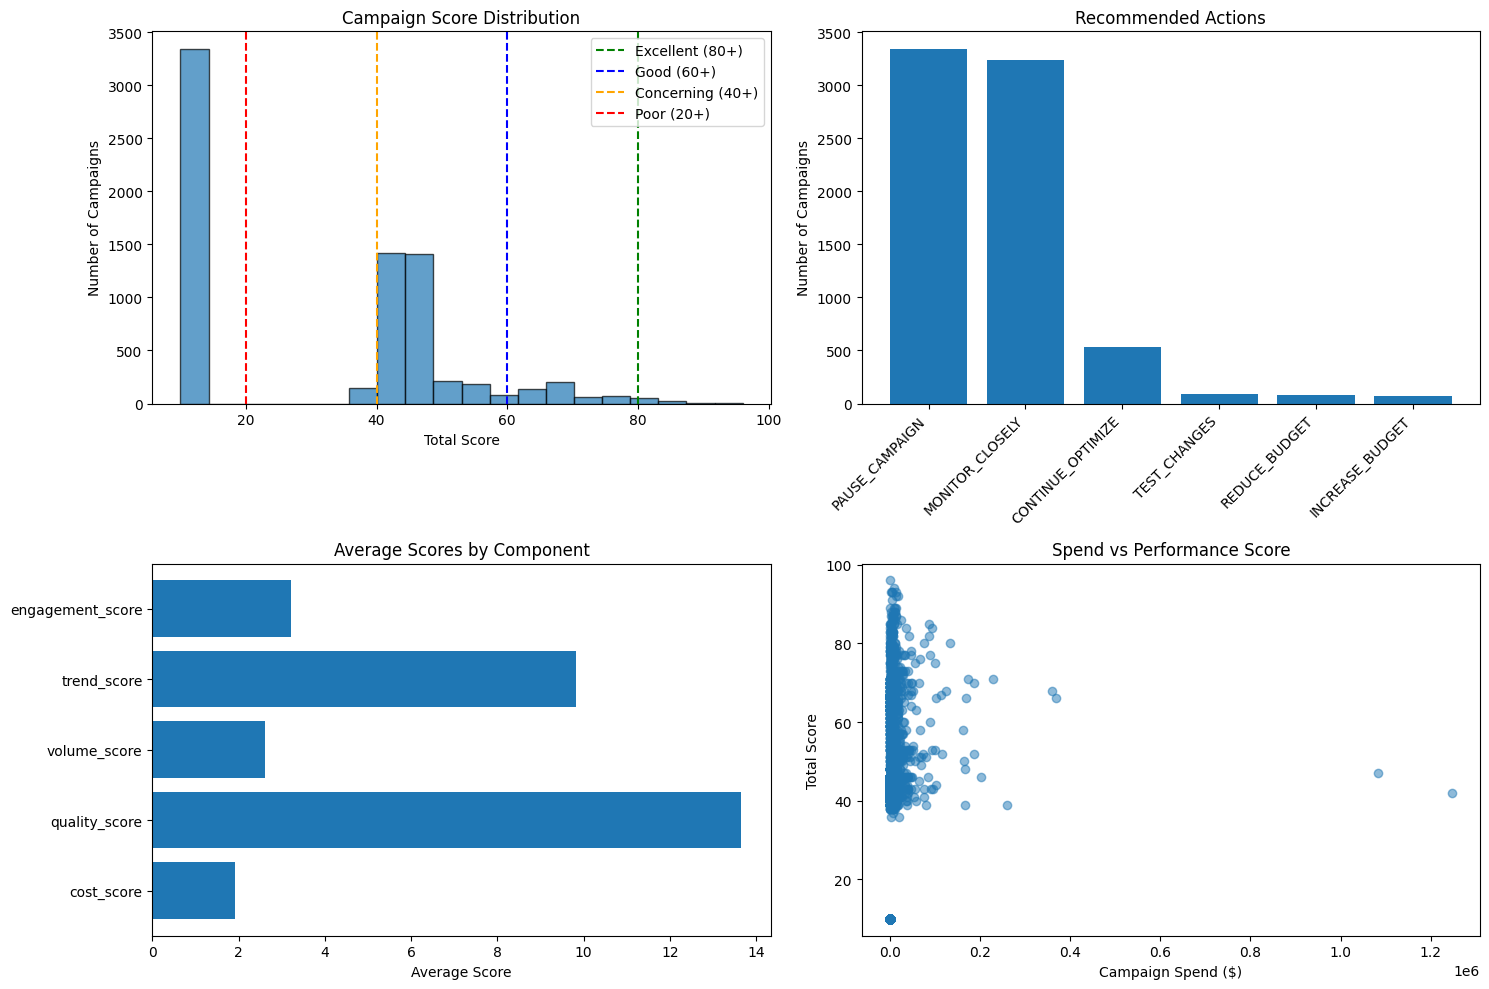


Visualization complete


In [15]:
# Action breakdown
print("\nRecommended Actions:")
action_summary = campaign_analysis.groupby('action').agg({
    'campaign_id': 'count',
    'cost': 'sum',
    'qualified_leads': 'sum',
    'total_score': 'mean'
}).round(2)
action_summary.columns = ['Campaign Count', 'Total Spend', 'Qualified Leads', 'Avg Score']
print(action_summary)

# Visualize score distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Score histogram
axes[0, 0].hist(campaign_analysis['total_score'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(80, color='green', linestyle='--', label='Excellent (80+)')
axes[0, 0].axvline(60, color='blue', linestyle='--', label='Good (60+)')
axes[0, 0].axvline(40, color='orange', linestyle='--', label='Concerning (40+)')
axes[0, 0].axvline(20, color='red', linestyle='--', label='Poor (20+)')
axes[0, 0].set_xlabel('Total Score')
axes[0, 0].set_ylabel('Number of Campaigns')
axes[0, 0].set_title('Campaign Score Distribution')
axes[0, 0].legend()

# Action distribution
action_counts = campaign_analysis['action'].value_counts()
axes[0, 1].bar(range(len(action_counts)), action_counts.values)
axes[0, 1].set_xticks(range(len(action_counts)))
axes[0, 1].set_xticklabels(action_counts.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Number of Campaigns')
axes[0, 1].set_title('Recommended Actions')

# Score components
score_cols = ['cost_score', 'quality_score', 'volume_score', 'trend_score', 'engagement_score']
avg_scores = campaign_analysis[score_cols].mean()
axes[1, 0].barh(score_cols, avg_scores)
axes[1, 0].set_xlabel('Average Score')
axes[1, 0].set_title('Average Scores by Component')

# Spend vs Score
axes[1, 1].scatter(campaign_analysis['cost'], campaign_analysis['total_score'], alpha=0.5)
axes[1, 1].set_xlabel('Campaign Spend ($)')
axes[1, 1].set_ylabel('Total Score')
axes[1, 1].set_title('Spend vs Performance Score')

plt.tight_layout()
plt.show()

print("\nVisualization complete")

## 6. Deep Dive: Analyze Specific Campaign Examples

Let's examine specific campaigns across different performance tiers to demonstrate the model's reasoning.

In [17]:
# Select example campaigns from each tier
examples = []

# Top performer
if len(campaign_analysis[campaign_analysis['total_score'] >= 80]) > 0:
    top = campaign_analysis[campaign_analysis['total_score'] >= 80].nlargest(1, 'total_score')
    examples.append(('Top Performer', top))

# Good performer
if len(campaign_analysis[(campaign_analysis['total_score'] >= 60) & (campaign_analysis['total_score'] < 80)]) > 0:
    good = campaign_analysis[(campaign_analysis['total_score'] >= 60) & (campaign_analysis['total_score'] < 80)].nlargest(1, 'total_score')
    examples.append(('Good Performer', good))

# Concerning
if len(campaign_analysis[(campaign_analysis['total_score'] >= 40) & (campaign_analysis['total_score'] < 60)]) > 0:
    concerning = campaign_analysis[(campaign_analysis['total_score'] >= 40) & (campaign_analysis['total_score'] < 60)].sample(1)
    examples.append(('Concerning', concerning))

# Poor performer
if len(campaign_analysis[campaign_analysis['total_score'] < 40]) > 0:
    poor = campaign_analysis[campaign_analysis['total_score'] < 40].nsmallest(1, 'total_score')
    examples.append(('Poor Performer', poor))

# Display detailed analysis for each example
for label, example in examples:
    print(f"\n{'='*80}")
    print(f"{label.upper()}")
    print(f"{'='*80}")
    
    row = example.iloc[0]
    
    print(f"\nCampaign: {row['campaign_name']} (ID: {row['campaign_id']})")
    print(f"Duration: {row['start_date'].date()} to {row['end_date'].date()} ({row['duration_days']} days)")
    
    print(f"\n--- Performance Metrics ---")
    print(f"Total Spend: ${row['cost']:,.2f}")
    print(f"Total Leads: {int(row['total_leads'])} | Qualified: {int(row['qualified_leads'])}")
    print(f"Cost per Lead: ${row['cpl']:,.2f}" if row['cpl'] != np.inf else "Cost per Lead: N/A")
    print(f"Cost per Qualified Lead: ${row['cpql']:,.2f}" if row['cpql'] != np.inf else "Cost per Qualified Lead: N/A (no qualified leads)")
    print(f"Qualification Rate: {row['qualification_rate']:.1%}")
    print(f"Click-through Rate: {row['ctr']:.2%}")
    print(f"Conversion Rate: {row['conversion_rate']:.2%}")
    
    print(f"\n--- Score Breakdown ---")
    print(f"Cost Efficiency: {row['cost_score']:.0f}/25")
    print(f"Lead Quality: {row['quality_score']:.0f}/25")
    print(f"Volume: {row['volume_score']:.0f}/20")
    print(f"Trend: {row['trend_score']:.0f}/20")
    print(f"Engagement: {row['engagement_score']:.0f}/10")
    print(f"TOTAL SCORE: {row['total_score']:.0f}/100")
    
    print(f"\n--- Recommendation ---")
    print(f"Action: {row['action']}")
    print(f"Rationale: {row['recommendation']}")
    
    # Additional reasoning
    print(f"\n--- Detailed Reasoning ---")
    if row['total_score'] >= 80:
        print("This campaign demonstrates exceptional performance across all dimensions.")
        if row['qualified_leads'] > 0:
            print(f"With a CPQL of ${row['cpql']:.2f} and {row['qualification_rate']:.1%} qualification rate,")
            print("it's significantly outperforming benchmarks. The business should allocate more budget here.")
    elif row['total_score'] >= 60:
        print("This campaign shows solid performance with room for optimization.")
        print("Continue running while testing improvements to creative or targeting.")
    elif row['total_score'] >= 40:
        print("This campaign has concerning metrics that warrant attention.")
        if row['qualified_leads'] < 5:
            print("However, sample size is still small. Recommend continuing for more data.")
        else:
            print("With sufficient data showing underperformance, test significant changes.")
    else:
        print("This campaign is significantly underperforming.")
        if row['qualified_leads'] > 0 and row['cpql'] > 3000:
            print(f"CPQL of ${row['cpql']:.2f} is far above target. This is not sustainable.")
        if row['qualification_rate'] < 0.05:
            print(f"Qualification rate of {row['qualification_rate']:.1%} indicates poor targeting or lead quality.")
        print("Immediate action required to stop capital burn.")


TOP PERFORMER

Campaign: Mountain View iCity October (ID: 10276)
Duration: 2024-09-04 to 2024-09-13 (9 days)

--- Performance Metrics ---
Total Spend: $864.63
Total Leads: 16 | Qualified: 9
Cost per Lead: $54.04
Cost per Qualified Lead: $96.07
Qualification Rate: 56.2%
Click-through Rate: 3.59%
Conversion Rate: 18.18%

--- Score Breakdown ---
Cost Efficiency: 25/25
Lead Quality: 25/25
Volume: 16/20
Trend: 20/20
Engagement: 10/10
TOTAL SCORE: 96/100

--- Recommendation ---
Action: INCREASE_BUDGET
Rationale: Excellent performance - increase budget by 30-50%

--- Detailed Reasoning ---
This campaign demonstrates exceptional performance across all dimensions.
With a CPQL of $96.07 and 56.2% qualification rate,
it's significantly outperforming benchmarks. The business should allocate more budget here.

GOOD PERFORMER

Campaign: Plage (ID: 6664)
Duration: 2024-06-06 to 2024-06-16 (10 days)

--- Performance Metrics ---
Total Spend: $6,330.67
Total Leads: 16 | Qualified: 7
Cost per Lead: $395

## 7. Priority Actions Report

Generate an actionable report for stakeholders showing which campaigns need immediate attention.

In [23]:
# High Priority: Campaigns to pause (burning money)
pause_campaigns = campaign_analysis[campaign_analysis['action'] == 'PAUSE_CAMPAIGN'].sort_values('cost', ascending=False)

print("=" * 80)
print("URGENT: CAMPAIGNS TO PAUSE IMMEDIATELY")
print("=" * 80)
print(f"\nThese {len(pause_campaigns)} campaigns are critically underperforming and should be paused today.")
print(f"Total spend at risk: ${pause_campaigns['cost'].sum():,.2f}\n")

if len(pause_campaigns) > 0:
    pause_report = pause_campaigns[['campaign_name', 'cost', 'qualified_leads', 
                                     'cpql', 'qualification_rate', 'total_score']].head(10)
    pause_report['cpql'] = pause_report['cpql'].replace(np.inf, 9999).round(2)
    print(pause_report.to_string(index=False))
else:
    print("No campaigns meet urgent pause criteria.")

print("\n" + "=" * 80)

# Medium Priority: Reduce budget
reduce_campaigns = campaign_analysis[campaign_analysis['action'] == 'REDUCE_BUDGET'].sort_values('cost', ascending=False)

print("\nHIGH PRIORITY: REDUCE BUDGET ON THESE CAMPAIGNS")
print("=" * 80)
print(f"\n{len(reduce_campaigns)} campaigns showing poor performance. Recommend 50% budget reduction.\n")

if len(reduce_campaigns) > 0:
    reduce_report = reduce_campaigns[['campaign_name', 'cost', 'qualified_leads', 
                                       'cpql', 'total_score']].head(10)
    reduce_report['cpql'] = reduce_report['cpql'].replace(np.inf, 9999).round(2)
    print(reduce_report.to_string(index=False))
else:
    print("No campaigns meet budget reduction criteria.")

print("\n" + "=" * 80)

# Opportunity: Increase budget on winners
increase_campaigns = campaign_analysis[campaign_analysis['action'] == 'INCREASE_BUDGET'].sort_values('total_score', ascending=False)

print("\nOPPORTUNITY: SCALE THESE HIGH PERFORMERS")
print("=" * 80)
print(f"\n{len(increase_campaigns)} campaigns performing excellently. Recommend 30-50% budget increase.\n")

if len(increase_campaigns) > 0:
    increase_report = increase_campaigns[['campaign_name', 'cost', 'qualified_leads', 
                                           'cpql', 'qualification_rate', 'total_score']].head(10)
    increase_report['cpql'] = increase_report['cpql'].round(2)
    print(increase_report.to_string(index=False))
else:
    print("No campaigns meet scaling criteria.")

print("\n" + "=" * 80)

URGENT: CAMPAIGNS TO PAUSE IMMEDIATELY

These 3342 campaigns are critically underperforming and should be paused today.
Total spend at risk: $0.00

                    campaign_name  cost  qualified_leads   cpql  qualification_rate  total_score
       [East] Skyrise - Binghatti   0.0              0.0 9999.0                 0.0           10
             New Capital- General   0.0              0.0 9999.0                 0.0           10
                 Dejoya Residence   0.0              0.0 9999.0                 0.0           10
Mar Bay - Al Marasem Ras El Hekma   0.0              0.0 9999.0                 0.0           10
                            Plage   0.0              0.0 9999.0                 0.0           10
                            Plage   0.0              0.0 9999.0                 0.0           10
                   arkan palm 205   0.0              0.0 9999.0                 0.0           10
                   arkan palm 205   0.0              0.0 9999.0             

In [20]:
# Calculate potential savings and opportunities
total_wasted = pause_campaigns['cost'].sum() + reduce_campaigns['cost'].sum() * 0.5
potential_scale = increase_campaigns['cost'].sum() * 0.4  # 40% increase on winners

print("\nFINANCIAL IMPACT SUMMARY")
print("=" * 80)
print(f"Estimated monthly waste to eliminate: ${total_wasted:,.2f}")
print(f"Recommended investment in winners: ${potential_scale:,.2f}")
print(f"Net reallocation: ${potential_scale - total_wasted:,.2f}")
print("\nBy stopping underperformers and scaling winners, we can improve overall ROAS")
print("while maintaining or potentially reducing total spend.")


FINANCIAL IMPACT SUMMARY
Estimated monthly waste to eliminate: $442,217.11
Recommended investment in winners: $388,125.04
Net reallocation: $-54,092.07

By stopping underperformers and scaling winners, we can improve overall ROAS
while maintaining or potentially reducing total spend.


## 8. Export Recommendations for Stakeholders

In [22]:
# Create executive summary report
output_columns = [
    'campaign_id', 'campaign_name',
    'cost', 'total_leads', 'qualified_leads', 'cpql', 'qualification_rate',
    'ctr', 'total_score', 'action', 'recommendation'
]

executive_report = campaign_analysis[output_columns].copy()
executive_report['cpql'] = executive_report['cpql'].replace(np.inf, None)
executive_report = executive_report.sort_values('total_score', ascending=False)

# Save to CSV
executive_report.to_csv('campaign_recommendations.csv', index=False)
print("Executive report saved to: campaign_recommendations.csv")

# Create action-specific reports
for action in campaign_analysis['action'].unique():
    action_df = campaign_analysis[campaign_analysis['action'] == action][output_columns]
    action_df['cpql'] = action_df['cpql'].replace(np.inf, None)
    filename = f'campaigns_{action.lower()}.csv'
    action_df.to_csv(filename, index=False)
    print(f"Action report saved to: {filename}")

print("\nAll reports generated successfully!")

Executive report saved to: campaign_recommendations.csv
Action report saved to: campaigns_pause_campaign.csv
Action report saved to: campaigns_continue_optimize.csv
Action report saved to: campaigns_monitor_closely.csv
Action report saved to: campaigns_test_changes.csv
Action report saved to: campaigns_reduce_budget.csv
Action report saved to: campaigns_increase_budget.csv

All reports generated successfully!


## 9. Model Assumptions and Refinement Questions

### Key Assumptions Made
1. **Target CPQL = $100**: This assumes qualified leads convert at a rate that makes $100 per lead profitable
2. **Minimum 5 qualified leads**: Statistical significance threshold for decision-making
3. **15% target qualification rate**: Based on industry benchmarks for real estate leads
4. **Equal weighting philosophy**: Cost efficiency and quality are weighted equally (25 points each)

### Critical Questions for Stakeholders

#### Business Model Questions
1. What is the actual conversion rate from qualified lead to closed deal?
2. What is the average commission/profit per closed deal?
3. What is the acceptable CAC (Customer Acquisition Cost) to remain profitable?
4. Are there different value tiers for leads (residential vs commercial, price ranges)?

#### Strategic Questions
5. Are there campaigns running for brand awareness that shouldn't be judged purely on lead metrics?
6. What is the acceptable testing period for new campaigns before making cut decisions?
7. Are there seasonal patterns we should account for in performance evaluation?
8. Do different platforms have different strategic importance beyond just performance?

#### Operational Questions
9. How quickly can budget changes be implemented (daily, weekly)?
10. Are there contractual minimums that prevent immediate pause of campaigns?
11. What is the team's capacity to manage optimization tests on concerning campaigns?
12. Should we consider lead lifetime value in addition to immediate qualification?

### Recommended Refinements
- **Dynamic thresholds**: Adjust targets based on seasonality, market conditions
- **Platform-specific benchmarks**: Different targets for Google vs Facebook vs LinkedIn
- **Lead value weighting**: Incorporate actual conversion and revenue data when available
- **Predictive component**: Add early warning signals for campaigns trending downward
- **A/B test framework**: Systematic testing protocol for concerning campaigns